In [0]:
!pip install nltk

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-7961011f-718e-448e-8e58-beec287345e9/bin/python -m pip install --upgrade pip' command.


In [0]:
!pip install beautifulsoup4

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-7961011f-718e-448e-8e58-beec287345e9/bin/python -m pip install --upgrade pip' command.


In [0]:
#doanloading nltk library
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Out[23]: True

In [0]:
from pyspark.sql.functions import sum, regexp_replace, col, explode, desc, split, year
from pyspark.sql.types import IntegerType, FloatType, DataType, TimestampType, StringType, StructType, StructField, ArrayType
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from bs4 import BeautifulSoup
import string
import re
import matplotlib.pyplot as plt
from collections import defaultdict


#### Importing files into dataframes

In [0]:
from pyspark.sql.functions import sum
from pyspark.sql.types import IntegerType, FloatType, DataType, TimestampType, StringType, StructType, StructField


# File location
filename1 = "/FileStore/tables/Assignment1/SO_ML.csv"
filename2 = "/FileStore/tables/Assignment1/SO_Spark.csv"
filename3 = "/FileStore/tables/Assignment1/SO_Security.csv"

#Function to import csv files
def import_csv(filename):
     #creating schema to ensure files are in appropriate format.
    new_Schema = StructType([ StructField("Id", IntegerType(), True),
                      StructField("PostTypeId", IntegerType(), True),
                      StructField("AcceptedAnswerId", IntegerType(), True),
                      StructField("ParentId", IntegerType(), True),
                       StructField("CreationDate", TimestampType(), True),
                       StructField("DeletionDat", TimestampType(), True),
                       StructField("Score", IntegerType(), True),
                       StructField("ViewCount", IntegerType(), True),
                       StructField("Body", StringType(), True),
                       StructField("OwnerUserId", IntegerType(), True),
                       StructField("OwnerDisplayName", StringType(), True),
                       StructField("LastEditorUserId", IntegerType(), True),
                       StructField("LastEditorDisplayName", StringType(), True),
                       StructField("LastEditDate", TimestampType(), True),
                       StructField("LastActivityDate", TimestampType(), True),
                       StructField("Title", StringType(), True),
                       StructField("Tags", StringType(), True),
                       StructField("AnswerCount", IntegerType(), True),
                       StructField("CommentCount", IntegerType(), True),
                       StructField("FavoriteCount", IntegerType(), True),
                       StructField("ClosedDate", TimestampType(), True),
                       StructField("CommunityOwnedDate", TimestampType(), True),
                       StructField("ContentLicense", StringType(), True)
                      ])


    # CSV options
    infer_schema = "false"
    first_row_is_header = "true"
    delimiter = ","
    multiLine = "true"
    escape = "\""

    # CSV options
    file_type = "csv"
    infer_schema = "true"
    first_row_is_header = "true"
    delimiter = ","
    
    #loading file
    df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .option("multiLine", multiLine) \
  .option("escape", escape) \
  .schema(new_Schema) \
  .load("/FileStore/tables/Assignment1/"+filename)
    
    return df    

#function to perform column arithmetic (row count and sum of column values)
def column_sum(df, col_name):
    #Using count() to count the number of rows
    row_count = df.count()
    print("The total number of ViewCount in the file is: " + str(row_count))
    #Using sum() to calculate the sum of the ViewCounts and displaying it.
    df.select(sum(col_name)).show()

#assigning the names of the files into variables
file_ML = "SO_ML.csv"
file_Spark = "SO_Spark.csv"
file_Security = "SO_Security.csv"

#importing each file
df_ML = import_csv(file_ML)
df_Spark = import_csv(file_Spark)
df_Security = import_csv(file_Security)

### 1. Preprocessing of data in Files

In [0]:
#parsing html text in words
@udf
def preProcessText(body):
    newBody=""
    #soups = BeautifulSoup(body, "html.parser").find_all("p")
    soups = BeautifulSoup(body, "html.parser")
    
    #code tag is removed
    for data in soups(['code']):
        data.decompose()
    
    #content of remainder tags extracted
    for d in soups:
        newBody+=d.get_text().lower()
    return newBody
    
#     for soup in soups:
#         newBody+=soup.get_text().lower()
#     return newBody

#Parsing all data files
newML = df_ML.select("*",preProcessText("Body").alias("newBody"))
newSpark = df_Spark.select("*",preProcessText("Body").alias("newBody"))
newSecurity = df_Security.select("*",preProcessText("Body").alias("newBody"))


In [0]:
#Function to remove stopwords 
@udf
def removeStopWords(sentences):
    noStopWords = []
    stopword = stopwords.words('english')
    #print(stopword)
    for sentence in sent_tokenize(sentences): #breaking into sentences
        for word in word_tokenize(sentence): #breaking into words
            if word not in stopword and len(word)>2: #removing stopwords and other irrelevant words
                if "n't" not in word: #because words like "doest" appear before doesn't leaving alot of "n't"
                    noStopWords.append(word)
    return ' '.join(noStopWords)

#Removing stopwords from files
newMLnonstop = newML.withColumn("noStopwords", removeStopWords("newBody"))
newSparknonstop = newSpark.withColumn("noStopwords", removeStopWords("newBody"))
newSecuritynonstop = newSecurity.withColumn("noStopwords", removeStopWords("newBody"))

In [0]:
#UDF to remove puntuations and non-alphabets
@udf
def removePuncNonalphabets(column):
#     df = df.withColumn("cleanWords", regexp_replace("noStopwords","[^\w\s]+", ""))
#     df = df.withColumn("cleanWords", regexp_replace("cleanWords","\d+", ""))
#     col1 = regexp_replace(col(column),"\d+", "")
    #column = ''.join(column)
    #print(column)
    
    #using regex to extract only alphabets and whitespaces
    return re.sub('[^a-zA-Z\s]+', "",column)
    
#removing punctuation and non-alphabets
filtered_ML = newMLnonstop.withColumn("cleanWords", removePuncNonalphabets("noStopwords"))
filtered_Spark = newSparknonstop.withColumn("cleanWords", removePuncNonalphabets("noStopwords"))
filtered_Security = newSecuritynonstop.withColumn("cleanWords", removePuncNonalphabets("noStopwords"))
#display(filtered_Security)

### 2. Counting frequency of words in each file (top 10).

Displaying word count for ML
Top 10 frequent words:
       word  count
0      data  38643
1     model  37482
2     using  30337
3      code  26309
4       use  20497
5  training  19915
6      like  19909
7     error  19025
8     would  17008
9       get  16367


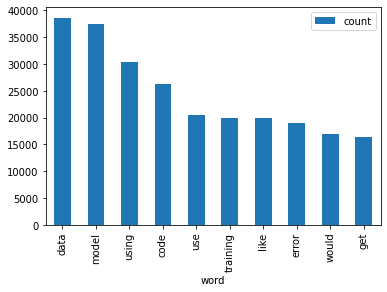

Displaying word count for Spark
Top 10 frequent words:
        word  count
0      spark  59754
1       data  31221
2      using  29800
3       code  22591
4       like  22506
5      error  19883
6       file  19344
7  dataframe  18818
8       want  17192
9        get  15923


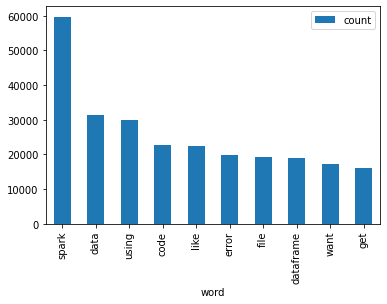

Displaying word count for Security
Top 10 frequent words:
          word  count
0         user  35930
1        using  27485
2     security  26135
3       server  24170
4        would  23242
5          use  22161
6         like  21461
7         code  20332
8  application  19414
9       access  17403


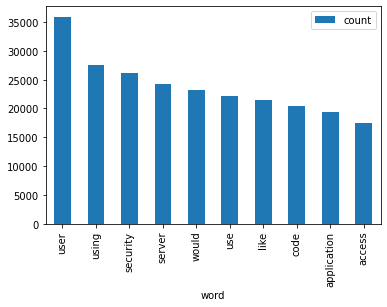

In [0]:
#Function to count number of words by passing dataframe and column name
def wordCounter(df, cName):
    #explode used to extract all rows in the target column and groupBy and count used to count words
    dfFreq= df.select(explode(split(col(cName)," ")).alias("word"))\
    .where(col("word") != '')\
    .groupby("word")\
    .count().orderBy(desc("count"))
    
    #extracting only top 10 words
    top10 = dfFreq.limit(10).toPandas()
    print("Top 10 frequent words:")
    print(top10)
    top10.plot(kind="bar", x="word", y="count")
    plt.show()
    return top10

#applying word counter function to all dataframes
print("Displaying word count for ML")
dfTop_ML = wordCounter(filtered_ML,"cleanWords")
print("Displaying word count for Spark")
dfTop_Spark = wordCounter(filtered_Spark,"cleanWords")
print("Displaying word count for Security")
dfTop_Security = wordCounter(filtered_Security,"cleanWords")    

### 2b. Counting frequency of words in combined data (top 30).

Displaying word count for all 3 files
Top 30 frequent words:
         word   count
0        data  108507
1       using   90474
2       model   77269
3        code   75209
4        like   62324
5       spark   61604
6       error   57933
7         use   56571
8        want   48794
9         get   48657
10      would   46660
11     trying   42332
12        one   42051
13   training   40475
14  following   38879
15    dataset   35673
16   function   34988
17       file   34516
18     output   34327
19        set   34110
20    problem   33679
21        way   32288
22      tried   30182
23    example   29458
24       know   28464
25       need   27684
26     values   27662
27   learning   26797
28      input   26584
29       also   25682


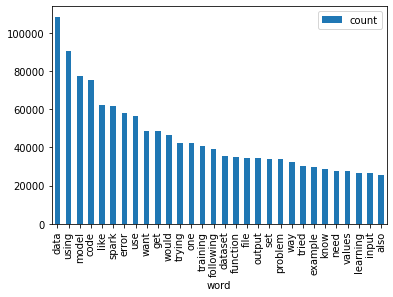

In [0]:
#similar word counter function as above but calulates top 30 most frequent words
def wordCounter30(df, cName):
    #df.select(explode(col(cName)).alias("wordings"))
    dfFreq= df.select(explode(split(col(cName)," ")).alias("word"))\
    .where(col("word") != '')\
    .groupby("word")\
    .count().orderBy(desc("count"))
    
    top30 = dfFreq.limit(30).toPandas()
    print("Top 30 frequent words:")
    print(top30)
    top30.plot(kind="bar", x="word", y="count")
    plt.show()
    return top30

#merging all 3 dataframes together
df_all=filtered_ML.union(filtered_Spark).union(filtered_ML)
print("Displaying word count for all 3 files")
#counting 30 most frequent words in merged dataframe
dfTop_ML = wordCounter30(df_all,"cleanWords")

### 3. Calculating percentage of questions without accepted answers in each file

In [0]:
#Function to calculate the number of null values in a given column of a dataframe
def questPerct(df, colName):
    nonNull = df.filter(col(colName).isNotNull()).count() #counting non-null values
    null  = df.filter(col(colName).isNull()).count() #counting null values
    perct = null / (nonNull+null) #estimating ratio of null values
    return perct*100

print("The percentage of unaccepted answers are:")
print("Machine Learning: {:.2f} %".format(questPerct(df_ML,"AcceptedAnswerID")))
print("Spark: {:.2f} %".format(questPerct(df_Spark,"AcceptedAnswerID")))
print("Security: {:.2f} %".format(questPerct(df_Security,"AcceptedAnswerID")))

The percentage of unaccepted answers are:
Machine Learning: 57.07 %
Spark: 56.65 %
Security: 47.47 %


### 4.  Calculating the total amount of posts created per year.

Displaying posts/year for ML
    CreationYear  count
0           2008      9
1           2009     94
2           2010    295
3           2011    504
4           2012   1032
5           2013   1500
6           2014   1731
7           2015   2618
8           2016   4720
9           2017   6776
10          2018   6908
11          2019   6548
12          2020   7808
13          2021   5172
14          2022   4285


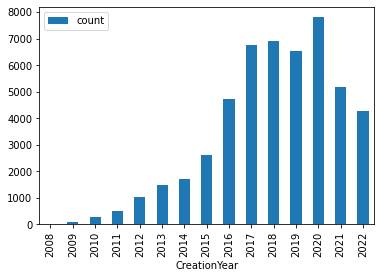

Displaying posts/year for Spark
    CreationYear  count
0           2011      1
1           2012      2
2           2013     61
3           2014   1203
4           2015   5102
5           2016   7985
6           2017   8285
7           2018   4401
8           2019   8770
9           2020   7092
10          2021   3112
11          2022   3986


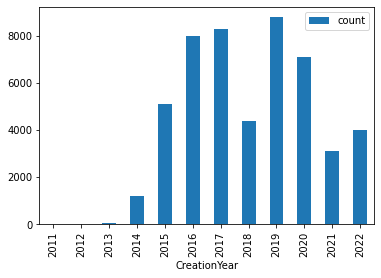

Displaying posts/year for Security
    CreationYear  count
0           2008    635
1           2009   2563
2           2010   3955
3           2011   5303
4           2012   5452
5           2013   5528
6           2014   5167
7           2015   4440
8           2016   3612
9           2017   3339
10          2018   2070
11          2019   2182
12          2020   2787
13          2021   1405
14          2022   1562


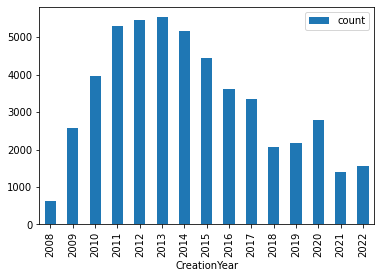

In [0]:
#Function to evaluate the number of posts generated per year in a  provided dataframe
def yearCounter(df):
    #Extracting year in date CreationDate column and storing it in new column CreationYear
    dfY = df.withColumn("CreationYear", year("CreationDate"))
    #Grouping and counting posts ceated per year
    dfCount = dfY.groupBy("CreationYear").count().orderBy("CreationYear")
    counter = dfCount.toPandas()
    print(counter)
    counter.plot(kind="bar", x="CreationYear", y="count")
    plt.show()

#Evaluating the posts created per year for each file
print("Displaying posts/year for ML")
dfYear_ML = yearCounter(df_ML)
print("Displaying posts/year for Spark")
dfYear_ML = yearCounter(df_Spark)
print("Displaying posts/year for Security")
dfYear_ML = yearCounter(df_Security)